In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, classification_report

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Set the path to your image folder
folder_path = 'datasets\\fer2013\\train\\sad'

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# List all image files in the folder
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Choose the number of augmented images you want
target_count = 2000
augmented_count = 0

# Loop until reaching the target count
while augmented_count < target_count:
    for img_path in image_files:
        if augmented_count >= target_count:
            break  # Exit the loop if the target count is reached

        # Load the image and convert it to a numpy array
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            augmented_count += 1
            if augmented_count >= target_count:
                break  # Exit the loop if the target count is reached


In [2]:
train_path="datasets\\fer2013\\train"
test_path="datasets\\fer2013\\test"
train_image_count = sum(len(files) for _, _, files in os.walk(train_path))
test_image_count = sum(len(files) for _, _, files in os.walk(test_path))
print(f"number of images in the train : {train_image_count}")
print(f"number of images in the test  : {test_image_count}")

number of images in the train : 97220
number of images in the test  : 14832


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

picture_size = (48,48)
batch_size = 120

datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(
    train_path,
    target_size=picture_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_set = datagen_val.flow_from_directory(
    test_path,
    target_size=picture_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 97220 images belonging to 7 classes.
Found 14832 images belonging to 7 classes.


In [4]:
# Get the class indices
class_indices = train_set.class_indices

# Invert the dictionary to map indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Count the number of images in each class
num_images_per_class = {class_labels[idx]: len(os.listdir(os.path.join(train_path, class_labels[idx]))) for idx in class_labels}

# Print the results
for class_label, num_images in num_images_per_class.items():
    print(f"Class: {class_label}, Number of Images: {num_images}")


Class: angry, Number of Images: 13509
Class: disgust, Number of Images: 12934
Class: fear, Number of Images: 13698
Class: happy, Number of Images: 14379
Class: neutral, Number of Images: 13882
Class: sad, Number of Images: 14822
Class: surprise, Number of Images: 13996


In [8]:
no_of_classes = 7

class_labels = train_set.classes
classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=class_labels)
class_weight_dict = dict(enumerate(class_weights))

model = Sequential()

model.add(Conv2D(64, (3, 3), padding="same", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st layer with L2 regularization
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Increase dropout rate

model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Increase dropout rate


model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Increase dropout rate

model.add(Dense(no_of_classes, activation="softmax"))
model.summary()


c:\Users\USER\Desktop\face_emotion_recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,056,711 (23.10 MB)

 Trainable params: 6,050,695 (23.08 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [9]:
checkpoint = ModelCheckpoint("./emotion_recognition1.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=1, restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=5,verbose=1, min_delta=0.001)

# Learning Rate Warm-up
warmup_epochs = 20
initial_lr = 0.001
final_lr = 0.01

def lr_scheduler(epoch, lr):
    if epoch < warmup_epochs:
        lr = initial_lr + epoch * ((final_lr - initial_lr) / warmup_epochs)
    return lr


scheduler = LearningRateScheduler(lr_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate, scheduler, tensorboard]

epochs = 200

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=initial_lr),
              metrics=['accuracy'])



In [10]:

history = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                class_weight=class_weight_dict,
                                callbacks=callbacks_list
                                )


Epoch 1/200


c:\Users\USER\Desktop\face_emotion_recognition\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


810/810 ━━━━━━━━━━━━━━━━━━━━ 757s 923ms/step - accuracy: 0.4717 - loss: 2.3007 - val_accuracy: 0.3450 - val_loss: 1.8951 - learning_rate: 0.0010
Epoch 2/200


c:\Users\USER\Desktop\face_emotion_recognition\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


810/810 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - accuracy: 0.6667 - loss: 0.5484 - val_accuracy: 0.2917 - val_loss: 1.2074 - learning_rate: 0.0014
Epoch 3/200


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2288.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


810/810 ━━━━━━━━━━━━━━━━━━━━ 723s 892ms/step - accuracy: 0.6422 - loss: 1.1064 - val_accuracy: 0.4600 - val_loss: 1.5293 - learning_rate: 0.0019
Epoch 4/200
810/810 ━━━━━━━━━━━━━━━━━━━━ 1s 189us/step - accuracy: 0.6583 - loss: 0.4738 - val_accuracy: 0.7778 - val_loss: 0.4462 - learning_rate: 0.0023
Epoch 5/200
810/810 ━━━━━━━━━━━━━━━━━━━━ 696s 859ms/step - accuracy: 0.6768 - loss: 1.0277 - val_accuracy: 0.4770 - val_loss: 1.5907 - learning_rate: 0.0028
Epoch 6/200
810/810 ━━━━━━━━━━━━━━━━━━━━ 1s 172us/step - accuracy: 0.6750 - loss: 0.5233 - val_accuracy: 0.6528 - val_loss: 0.7962 - learning_rate: 0.0033
Epoch 7/200
810/810 ━━━━━━━━━━━━━━━━━━━━ 673s 830ms/step - accuracy: 0.6939 - loss: 1.0320 - val_accuracy: 0.4354 - val_loss: 1.8511 - learning_rate: 0.0037
Epoch 8/200
810/810 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step - accuracy: 0.7333 - loss: 0.4715 - val_accuracy: 0.5139 - val_loss: 0.9683 - learning_rate: 0.0041
Epoch 9/200
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7112 - 

In [30]:
# Generate predictions for the test set
predictions = model.predict(test_set)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_labels = test_set.classes

# Get class names
class_names = list(test_set.class_indices.keys())

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))


124/124 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.86      0.76      0.81      1918
     disgust       0.99      0.98      0.99       810
        fear       0.80      0.71      0.75      2042
       happy       0.96      0.95      0.95      3599
     neutral       0.81      0.87      0.84      2449
         sad       0.72      0.82      0.77      2386
    surprise       0.92      0.91      0.92      1628

    accuracy                           0.85     14832
   macro avg       0.86      0.86      0.86     14832
weighted avg       0.86      0.85      0.85     14832



In [31]:
test_loss, test_accuracy = model.evaluate(test_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


124/124 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.8254 - loss: 0.5488
Test Loss: 0.49794694781303406
Test Accuracy: 0.8541666865348816


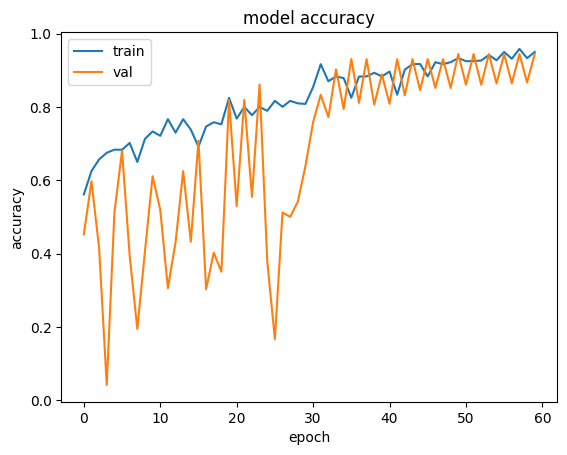

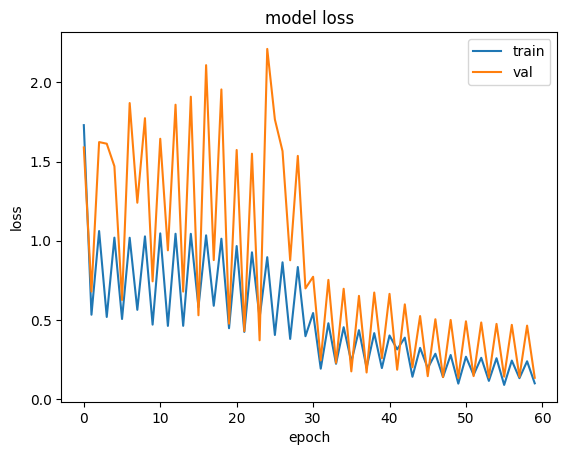

In [32]:
# Accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step


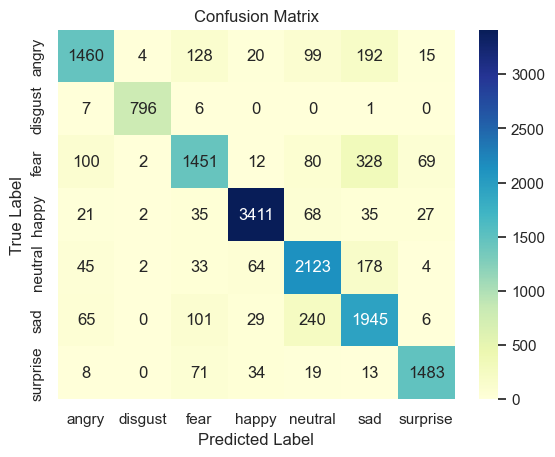

In [33]:
# Get the true labels and predicted labels for the validation set
validation_labels = test_set.classes
validation_pred_probs = model.predict(test_set)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_set.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()




In [34]:
# Define the file path where you want to save your model
model_path = 'emotion_detection_model.keras'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: emotion_detection_model.keras


In [35]:
# Define the file path where you want to save your model
model_path = 'face_emotion_model2.keras'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: face_emotion_model2.keras
